In [1]:
import numpy as np
import torch 
import torch.nn as nn
from tqdm import tnrange
import torch.optim as optim
import torch.nn.functional as F
from sklearn import metrics
import matplotlib.pyplot as plt
from sklearn.metrics import explained_variance_score
import scipy
import time

from models.sub_cos_glm import Sub_Cos_GLM
#from models.sub_tcn import Sub_TCN
#from models.gru import GRU
#from models.tcn_multilayer import TCN_Multilayer
#from models.lstm import LSTM
#from models.tcn import TCN
#from models.sub_cos_tcn import Sub_Cos_TCN
#from models.cos_tcn import Cos_TCN
#from models.gru_exp import GRU
#from models.gru_stacked import GRU_Stacked
#from models.dend_gru import Dend_GRU

In [2]:
base_dir = "/scratch/yjk27/"
experiment = "NA_NMDA"
cell_type = "CA1"
E_neural_file = "Espikes_neural.npz"
I_neural_file = "Ispikes_neural.npz"
#V_file  = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.6_Ni200_gG0.1_gB0.06_NA0.75_NMDA0.75_Er0.5_Ir7.4_random_NR_rep1000_stimseed1.npy"
#V_file = "vdata_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_noDendNa_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
V_file = "V_diff_NA1.5_NMDA0.75_stimseed1.npy"
#V_file = "V_diff_stimseed1_set1.npy"

#E_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+E_neural_file)
#I_neural = scipy.sparse.load_npz(base_dir+cell_type+"_"+experiment+"/data/"+I_neural_file)
E_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+E_neural_file)
I_neural = scipy.sparse.load_npz(base_dir+"CA1_clust4-60/data/"+I_neural_file)
#V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)[:,:50000].flatten()
V = np.load(base_dir+cell_type+"_"+experiment+"/data/"+V_file)
V = torch.from_numpy(V)
#V -= torch.mean(V)

"""
eloc_file = "Elocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
iloc_file = "Ilocs_T10_Ne2000_gA0.6_tauA1_gN0.8_Ni200_gG0.1_gB0.1_Er0.5_Ir7.4_random_NR_rep1000_stimseed1_set1.npy"
eloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+eloc_file)
iloc = np.load(base_dir+cell_type+"_"+experiment+"/data/"+iloc_file)

den_idx = np.unique(eloc[880:1120,0])
e_idx = np.where(np.isin(eloc[:,0], den_idx) == True)[0]
i_idx = np.where(np.isin(iloc[:,0], den_idx) == True)[0]
e_idx = torch.from_numpy(e_idx)
i_idx = torch.from_numpy(i_idx)
"""

#####
#V_test_raw = np.load("/media/hdd01/sklee/"+experiment+"/data/V_diff_stimseed1.npy")
#V_test_raw = torch.from_numpy(V_test_raw)
#V_test_raw -= torch.mean(V_test_raw)

#test_E_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Espikes_neural.npz")
#test_I_neural_raw = scipy.sparse.load_npz("/media/hdd01/sklee/"+experiment+"/data/Ispikes_neural.npz")
#####

C_syn_e = np.load(base_dir+"CA1_clust4-60"+"/data/handsub5_C_syn_e.npy")
C_syn_i = np.load(base_dir+"CA1_clust4-60"+"/data/handsub5_C_syn_i.npy")
C_syn_e = torch.from_numpy(C_syn_e).float()
C_syn_i = torch.from_numpy(C_syn_i).float()

#C_syn_e = C_syn_e[:,e_idx]
#C_syn_i = C_syn_i[:,i_idx]

In [3]:
T_train = 980 * 1000 * 50
T_test = 1 * 1000 * 50
H_no = 1
#sub_no = 1
E_no = 2000
I_no = 200
#E_no = e_idx.shape[0]
#I_no = i_idx.shape[0]
T_no = 500
#T_no = 350
device = torch.device("cuda:2")

#layer_no = 3

increment = 50
batch_length = 50000
batch_size = 5
iter_no = 9800*2
epoch_no = iter_no*batch_length*batch_size//T_train

In [4]:
V_train = V[:T_train].float()
V_test = V[-50000:].to(device).float()

#V_test = V_test_raw[50000*993:50000*994].to(device).float()

test_E_neural = E_neural[-50000:].toarray()
test_I_neural = I_neural[-50000:].toarray()
#test_E_neural = E_neural[50000*993:50000*994].toarray()
#test_I_neural = I_neural[50000*993:50000*994].toarray()
#test_E_neural = test_E_neural_raw[50000*993:50000*994].toarray()
#test_I_neural = test_I_neural_raw[50000*993:50000*994].toarray()
train_E_neural = E_neural[:T_train]
train_I_neural = I_neural[:T_train]

test_E_neural = torch.from_numpy(test_E_neural).float().to(device)
test_I_neural = torch.from_numpy(test_I_neural).float().to(device)

train_idx = np.empty((epoch_no, T_train//batch_length//batch_size))
for i in range(epoch_no):
    part_idx = np.arange(0, T_train, batch_length*batch_size)
    np.random.shuffle(part_idx)
    train_idx[i] = part_idx
train_idx = train_idx.flatten()
train_idx = torch.from_numpy(train_idx)

In [5]:
model = Sub_Cos_GLM(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = GRU_Stacked(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = Sub_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, device)
#model = LSTM(C_syn_e.to(device), C_syn_i.to(device), H_no, device)
#model = TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Sub_Cos_TCN(C_syn_e.to(device), C_syn_i.to(device), T_no, H_no, layer_no, device)
#model = Cos_TCN(E_no, I_no, T_no, H_no, layer_no, device)
#model = TCN_Multilayer(T_no-1, 2200, layer_no, H_no, device)
#model = Dend_GRU(C_syn_e.to(device), C_syn_i.to(device), H_no, device)

# GLM (1.025 for V_diff, 1 for noNA)
optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1.035**100))
milestones = np.arange(increment-1, increment*100, increment)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1.035)

# GRU (1 for V_diff, 1 for noNA)
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.005/(1**100))
#milestones = np.arange(increment-1, increment*100, increment)
#scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=milestones, gamma=1)

#TCN multilayer
#optimizer = torch.optim.Adam(model.parameters(), lr = 0.0025,
                             #weight_decay=0.0000001) # for TCNMUlti
                             #weight_decay=0)

model.to(device).float()
print(sum(p.numel() for p in model.parameters() if p.requires_grad))

2511


In [6]:
score_list = np.empty((iter_no))

for i in tnrange(iter_no):
#for i in tnrange(12000):
    model.train()
    optimizer.zero_grad()
    
    batch_idx = train_idx[i].long()
    batch_E_neural = train_E_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_I_neural = train_I_neural[batch_idx : batch_idx+batch_length*batch_size].toarray().reshape(batch_size, batch_length, -1)
    batch_E_neural = torch.from_numpy(batch_E_neural).float().to(device)
    batch_I_neural = torch.from_numpy(batch_I_neural).float().to(device)
    batch_V = V_train[batch_idx : batch_idx+batch_length*batch_size].reshape(batch_size, -1).to(device)
    
    V_pred, _, _ = model(batch_E_neural, batch_I_neural)
    #V_pred = model(batch_E_neural, batch_I_neural)
    #V_pred, _ = model(batch_E_neural[:,5000:35000,e_idx], batch_I_neural[:,5000:35000,i_idx])
    #V_pred = model(batch_E_neural, batch_I_neural)
    
    train_score = explained_variance_score(batch_V[:,:].flatten().cpu().detach().numpy(),
                                           V_pred.flatten().cpu().detach().numpy())
    
    loss = torch.mean((V_pred- batch_V[:,:] )**2)
    loss.backward()
    optimizer.step()
    #scheduler.step()
    
    if (i%50 == 49) or (i == 0):
        model.eval()
        test_V_pred, test_sub_out, _ = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        #test_V_pred, test_sub_out = model(test_E_neural.unsqueeze(0)[:,5000:35000,e_idx], test_I_neural.unsqueeze(0)[:,5000:35000,i_idx])
        #test_V_pred = model(test_E_neural.unsqueeze(0), test_I_neural.unsqueeze(0))
        test_V_pred = test_V_pred.flatten()
                 
        test_score = explained_variance_score(V_test.cpu().detach().numpy()[:], test_V_pred.cpu().detach().numpy())
        test_mse = torch.mean((V_test[:]-test_V_pred)**2).item()
        score_list[i//50] = test_score
                
        print(i, np.round(test_score,6),
              np.round(train_score,6))


<ipython-input-6-22e63835ac3f>:3: TqdmDeprecationWarning: Please use `tqdm.notebook.trange` instead of `tqdm.tnrange`
  for i in tnrange(iter_no):


  0%|          | 0/19600 [00:00<?, ?it/s]

0 -0.078269 -0.082326
49 0.104138 0.111216
99 0.150886 0.166489
149 0.167874 0.186147
199 0.178558 0.207767
249 0.186327 0.208866
299 0.192134 0.21813
349 0.196219 0.22415
399 0.199211 0.227181
449 0.202101 0.231715
499 0.204719 0.230138
549 0.206492 0.238595
599 0.208547 0.247561
649 0.210572 0.241512
699 0.211726 0.257682
749 0.213479 0.235858
799 0.214799 0.249114
849 0.216253 0.23091
899 0.217874 0.26503
949 0.218952 0.237991
999 0.220289 0.256729
1049 0.221488 0.273574
1099 0.222818 0.243971
1149 0.224116 0.266606
1199 0.225734 0.249591
1249 0.226322 0.269028
1299 0.227646 0.279748
1349 0.228967 0.258771
1399 0.230188 0.277389
1449 0.231253 0.271847
1499 0.231989 0.270594
1549 0.232979 0.28383
1599 0.233442 0.287923
1649 0.234812 0.279846
1699 0.23587 0.283143
1749 0.23658 0.255159
1799 0.237546 0.282687
1849 0.237625 0.277885
1899 0.238564 0.283792
1949 0.238905 0.281054
1999 0.239782 0.29808
2049 0.240388 0.282684
2099 0.240548 0.286781
2149 0.24114 0.287247
2199 0.241915 0.2839

17699 0.262855 0.310957
17749 0.262316 0.302941
17799 0.263391 0.312954
17849 0.262496 0.317652
17899 0.262375 0.295986


KeyboardInterrupt: 

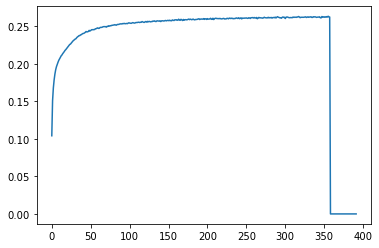

In [7]:
plt.plot(score_list[:392])
#plt.ylim(0,1)

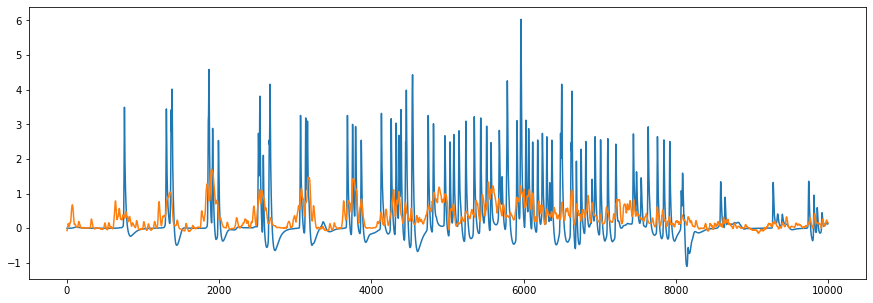

In [8]:
plt.figure(figsize = (15,5))
plt.plot(V_test.cpu().detach().numpy()[17000:27000])
plt.plot(test_V_pred.cpu().detach().numpy()[17000:27000])

In [10]:
#torch.save(model.state_dict(), "/scratch/yjk27/CA1_NA_NMDA/NA1.5_NMDA0.75/na_glm_s5_h1.pt")